In [7]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

In [8]:
data = pd.read_csv('data/hierarchical_labels.csv')
test_data = pd.read_csv('data/test_data/umist_test.csv')

In [9]:
X_train = data.drop(['label','cluster_id'],axis = 1)
X_train

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_10294,pixel_10295,pixel_10296,pixel_10297,pixel_10298,pixel_10299,pixel_10300,pixel_10301,pixel_10302,pixel_10303
0,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,233.000000,...,195.000000,195.000000,193.000000,192.000000,192.000000,192.000000,192.000000,191.000000,190.000000,191.000000
1,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,192.000000,192.000000,191.000000,186.000000,183.000000,179.000000,174.000000,169.000000,165.000000,164.000000
2,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,233.000000,225.000000,186.000000,...,192.000000,192.000000,191.000000,185.000000,184.000000,177.000000,170.000000,166.000000,164.000000,163.000000
3,234.000000,234.000000,234.000000,234.000000,233.000000,230.000000,225.000000,109.000000,85.000000,84.000000,...,180.000000,174.000000,168.000000,164.000000,157.000000,152.000000,151.000000,148.000000,145.000000,145.000000
4,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,...,192.000000,192.000000,191.000000,190.000000,188.000000,184.000000,177.000000,173.000000,168.000000,164.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,12.774262,14.900889,17.034262,16.753109,19.921688,32.031654,40.802284,38.213154,37.520039,41.379807,...,113.303436,93.813164,86.412865,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
596,34.614086,33.583519,31.000000,28.009336,23.638203,24.206892,22.209639,22.690187,20.699478,17.636459,...,115.571373,125.828773,134.128143,135.000000,135.000000,135.000000,134.090775,130.582047,110.805885,91.844559
597,12.382547,11.983182,11.583817,11.184451,11.286551,11.819038,12.351525,12.884012,13.416499,13.948986,...,79.849518,80.711899,82.771255,83.456573,84.608582,85.115562,85.000000,85.000000,85.000000,85.000000
598,12.370116,11.914194,11.458273,11.002351,11.604760,12.212656,12.820552,13.428447,14.036343,14.644238,...,83.477509,83.755440,86.950645,87.505348,87.967468,87.232796,85.579475,87.959824,86.000000,86.000000


In [10]:
y_train = data['cluster_id']
y_train

0      8
1      8
2      8
3      8
4      8
      ..
595    5
596    5
597    5
598    5
599    5
Name: cluster_id, Length: 600, dtype: int64

In [11]:
# Extract pixel values and reshape
data_array = X_train.values
num_samples = data_array.shape[0]

In [12]:
# Reshape into (num_samples, height, width, channels)
reshaped_images = data_array.reshape(num_samples, 112, 92, 1)  # Assuming grayscale
test_data = test_data.values.reshape(test_data.shape[0], 112, 92, 1)

In [13]:
# Normalize the images
reshaped_images = reshaped_images / 255.0
test_data = test_data/ 255.0

In [14]:
# Convert to TensorFlow tensors
image_tensors = tf.convert_to_tensor(reshaped_images, dtype=tf.float32)

In [15]:
print(f"Image tensor shape: {image_tensors.shape}")  # Should print (num_samples, 112, 92, 1)

Image tensor shape: (600, 112, 92, 1)


In [16]:
IMAGE_WIDTH = 112
IMAGE_HEIGHT = 92
NUM_CLASSES = 31
BATCH_SIZE = 32
EPOCHS = 10
NUMBER_OF_TRAINING_IMAGES = 600

In [17]:
model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 92, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 44, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 10, 128)      0

In [19]:
early_stopping = EarlyStopping()

In [20]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

In [21]:
history = model.fit(reshaped_images, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

Epoch 1/10


2024-12-02 15:47:05.889524: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 3s 114ms/step - loss: 11.6620 - accuracy: 0.0917
Epoch 2/10
19/19 [==============================] - 2s 104ms/step - loss: 7.2044 - accuracy: 0.1567
Epoch 3/10
19/19 [==============================] - 2s 102ms/step - loss: 4.9075 - accuracy: 0.2833
Epoch 4/10
19/19 [==============================] - 2s 101ms/step - loss: 3.5005 - accuracy: 0.5033
Epoch 5/10
19/19 [==============================] - 2s 102ms/step - loss: 2.7917 - accuracy: 0.5917
Epoch 6/10
19/19 [==============================] - 2s 101ms/step - loss: 2.2960 - accuracy: 0.7300
Epoch 7/10
19/19 [==============================] - 2s 101ms/step - loss: 1.9871 - accuracy: 0.7983
Epoch 8/10
19/19 [==============================] - 2s 110ms/step - loss: 1.7127 - accuracy: 0.8583
Epoch 9/10
19/19 [==============================] - 2s 99ms/step - loss: 1.6288 - accuracy: 0.8733
Epoch 10/10
19/19 [==============================] - 2s 98ms/step - loss: 1.4756 - accuracy: 0.9083


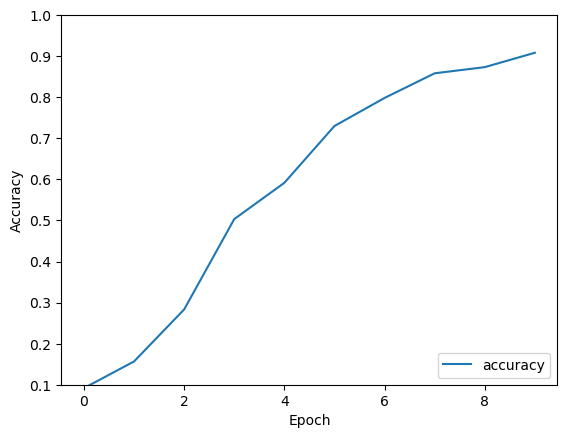

In [22]:
plot_folder = "plot"
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

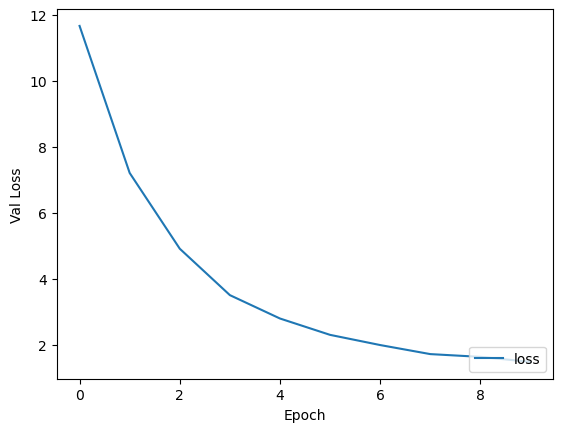

In [23]:
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')